In [1]:
from scipy.stats import jf_skew_t
from scipy.stats.sampling import NumericalInversePolynomial
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
from pysabr import Hagan2002NormalSABR
from fwdsabr.option_pricing import compute_option_prices
import warnings
# warnings.filterwarnings("ignore",)

In [2]:
class SabrDist(ss.rv_continuous):
    def __init__(self, f, shift, t, v_atm_n, beta, rho, volvol):
        super().__init__(name='SABR', a=-shift+1e-6, )
        self.sabr = Hagan2002NormalSABR(f=f, shift=shift, t=t, v_atm_n=v_atm_n, beta=beta, rho=rho, volvol=volvol)
    
    def _cdf(self, x):
        vols = self.sabr.normal_vol(x)
        return ss.norm.cdf(x, loc = self.sabr.f, scale = vols * np.sqrt(self.sabr.t))
    
    # def pdf(self, x):
    #     vols = self.sabr.normal_vol(x)
    #     # return ss.norm.pdf(x, loc = self.sabr.f, scale = vols * np.sqrt(self.sabr.t)) / (vols * np.sqrt(self.sabr.t))
    #     return ss.norm.pdf(x, loc = self.sabr.f, scale = vols * np.sqrt(self.sabr.t)) 
    

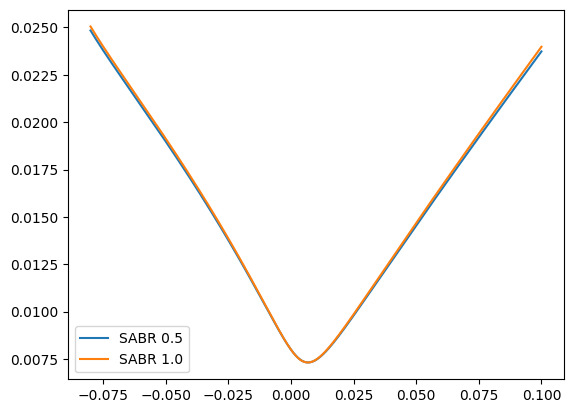

In [94]:
shift = 0.1
f = 0
strikes = np.linspace(-shift+0.02, shift, 1000)

sabr_p1 = Hagan2002NormalSABR(f = f, shift=shift, t = .5, v_atm_n=0.008, beta=0.5, rho=-0.5, volvol=.8)
sabr_p2 = Hagan2002NormalSABR(f = f, shift=shift, t = 1., v_atm_n=0.008, beta=0.5, rho=-0.5, volvol=.8)
sabr_dist_p1 = SabrDist(f=f, shift=shift, t=.5, v_atm_n=0.008, beta=0.5, rho=-0.5, volvol=.8)
sabr_dist_p2 = SabrDist(f=f, shift=shift, t=1, v_atm_n=0.008, beta=0.5, rho=-0.5, volvol=.8)
pdf_p1 = sabr_dist_p1.pdf(strikes) / sabr_dist_p1.pdf(strikes).sum()
pdf_p2 = sabr_dist_p2.pdf(strikes) / sabr_dist_p2.pdf(strikes).sum()
plt.plot(strikes, sabr_p1.normal_vol(strikes), label='SABR 0.5')
plt.plot(strikes, sabr_p2.normal_vol(strikes), label='SABR 1.0')
plt.legend()

In [95]:
sabr_p1_to_p2 = Hagan2002NormalSABR(f = f, shift=shift, t = .5, v_atm_n=0.008, beta=0.5, rho=-0.5, volvol=.8)
pdf_p1_p2 = sabr_p1_to_p2.normal_vol(strikes) / sabr_p1_to_p2.normal_vol(strikes).sum()
vols_p1_p2 = sabr_p1_to_p2.normal_vol(strikes)

In [96]:
prices_terminal = compute_option_prices(F=strikes, K=0, vol=sabr_p2.normal_vol(strikes), T = .0001, call_put='call')

In [102]:
compute_option_prices(F=0, K=0, vol=sabr_p2.normal_vol(1e-9), T = 1, call_put='call')

array([0.00319154])

In [98]:
sampled = (np.random.randn(10_000, vols_p1_p2.shape[0]) * vols_p1_p2 * np.sqrt(.5)) + strikes
sampled.shape

(10000, 1000)

np.float64(0.00305857498245344)

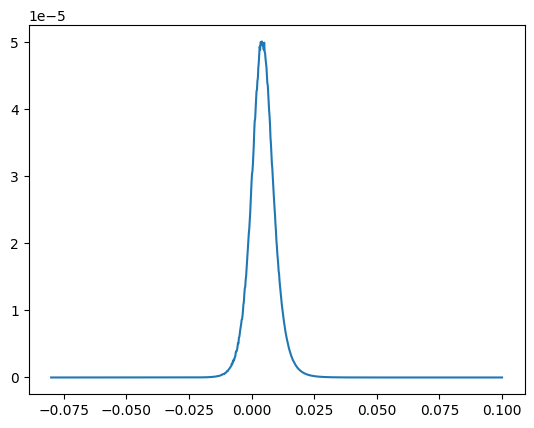

In [99]:
plt.plot(strikes, np.maximum(sampled, 0).mean(axis=0) * pdf_p1)
(np.maximum(sampled, 0).mean(axis=0) * pdf_p1).sum()

np.float64(0.0031230272122513376)

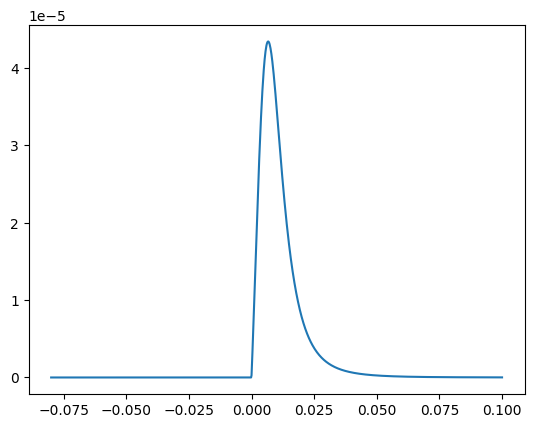

In [100]:
plt.plot(strikes, prices_terminal * pdf_p2, label = 'P2 Dist PDF * Call Price 1.0')
(prices_terminal * pdf_p2).sum()

In [65]:
np.maximum(sampled, 0).mean(axis=0)

array([0.00000000e+00, 9.10679843e-08, 0.00000000e+00, 0.00000000e+00,
       2.84915096e-08, 0.00000000e+00, 1.34771528e-07, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.25141351e-08, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.08013440e-08,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.62162883e-07,
       0.00000000e+00, 0.00000000e+00, 8.09511121e-09, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.10914994e-08, 1.57547920e-08, 0.00000000e+00, 0.00000000e+00,
       7.54380712e-09, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.03476622e-08, 0.00000000e+00, 9.81574430e-08, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.04567095e-08, 0.00000000e+00,
       5.56981731e-08, 0.00000000e+00, 8.78628304e-09, 0.00000000e+00,
      

In [ ]:
prices_atm = np.mean(np.maximum(sampled , 0) * pdf_p1, 0)


(1000,)

In [35]:
prices_1y = compute_option_prices(F=f, K=strikes, vol=sabr_p2.normal_vol(strikes), T=1., call_put='call')
prices_1y

array([8.00047549e-02, 7.98246056e-02, 7.96444569e-02, 7.94643088e-02,
       7.92841615e-02, 7.91040148e-02, 7.89238687e-02, 7.87437234e-02,
       7.85635787e-02, 7.83834346e-02, 7.82032913e-02, 7.80231486e-02,
       7.78430067e-02, 7.76628654e-02, 7.74827248e-02, 7.73025849e-02,
       7.71224456e-02, 7.69423071e-02, 7.67621693e-02, 7.65820323e-02,
       7.64018959e-02, 7.62217602e-02, 7.60416253e-02, 7.58614911e-02,
       7.56813577e-02, 7.55012250e-02, 7.53210930e-02, 7.51409618e-02,
       7.49608314e-02, 7.47807017e-02, 7.46005728e-02, 7.44204447e-02,
       7.42403174e-02, 7.40601909e-02, 7.38800652e-02, 7.36999403e-02,
       7.35198162e-02, 7.33396930e-02, 7.31595706e-02, 7.29794490e-02,
       7.27993283e-02, 7.26192085e-02, 7.24390895e-02, 7.22589715e-02,
       7.20788543e-02, 7.18987380e-02, 7.17186226e-02, 7.15385082e-02,
       7.13583947e-02, 7.11782821e-02, 7.09981705e-02, 7.08180598e-02,
       7.06379502e-02, 7.04578415e-02, 7.02777338e-02, 7.00976271e-02,
      

In [79]:
# plt.plot(strikes[1:], np.diff(sabr_dist_p1.cdf(strikes)), label='SABR Dist PDF')
# plt.plot(strikes, sabr_dist_p1.pdf(strikes) / sabr_dist_p1.pdf(strikes).sum(), label='SABR Dist PDF') # Sanity check


/Users/davidserero/Documents/Python/FwdSabr/src/fwdsabr/option_pricing.py:21: RuntimeWarning: divide by zero encountered in divide
  S_d1 = F + vol * np.sqrt(T) * alpha_pdf / (1 - alpha_cdf)
/Users/davidserero/Documents/Python/FwdSabr/src/fwdsabr/option_pricing.py:21: RuntimeWarning: invalid value encountered in divide
  S_d1 = F + vol * np.sqrt(T) * alpha_pdf / (1 - alpha_cdf)
/Users/davidserero/Documents/Python/FwdSabr/src/fwdsabr/option_pricing.py:27: RuntimeWarning: divide by zero encountered in divide
  S_d1 = F - vol * np.sqrt(T) * alpha_pdf / alpha_cdf
/Users/davidserero/Documents/Python/FwdSabr/src/fwdsabr/option_pricing.py:27: RuntimeWarning: invalid value encountered in divide
  S_d1 = F - vol * np.sqrt(T) * alpha_pdf / alpha_cdf


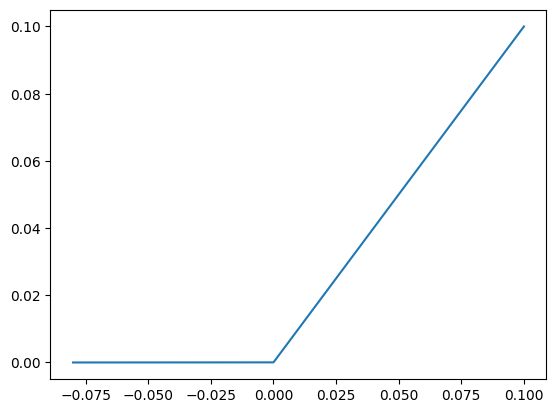

In [28]:
prices_p1 = compute_option_prices(F=f, K=strikes, vol=sabr_p1.normal_vol(strikes), T = .5, call_put='call')
# prices_p2 = compute_option_prices(F=f, K=strikes, vol=sabr_p2.normal_vol(strikes), T = 1.0, call_put='call')
prices_p2 = compute_option_prices(F=strikes, K=0, vol=sabr_p2.normal_vol(strikes), T = .0001, call_put='call')
# plt.plot(strikes, np.log(prices_p1), label='Call Price 0.5')
plt.plot(strikes, (prices_p2), label='Call Price 0.5')

In [ ]:

prices_p1_p2 = compute_option_prices(F=0, K=0, vol=vols_p1_p2, T = .5, call_put='call')

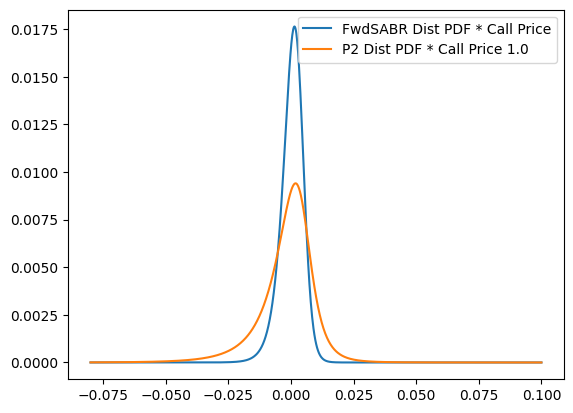

In [ ]:

# pdf_p1_then_p2 = pdf_p1 * pdf_p2
# pdf_p1_then_p2 = pdf_p1_then_p2 / pdf_p1_then_p2.sum()
plt.plot(strikes, (pdf_p1_p2 * ), label = 'FwdSABR Dist PDF * Call Price')
plt.plot(strikes, pdf_p2, label = 'P2 Dist PDF * Call Price 1.0')
plt.legend()

In [31]:
(pdf_p1_p2 * pdf_p1).sum()

np.float64(0.0005401283638514559)

In [18]:
prices_p1_p2

array([0.00700724, 0.00699621, 0.00698522, 0.00697427, 0.00696336,
       0.00695249, 0.00694166, 0.00693087, 0.00692012, 0.0069094 ,
       0.00689871, 0.00688806, 0.00687744, 0.00686685, 0.00685629,
       0.00684576, 0.00683526, 0.00682479, 0.00681435, 0.00680393,
       0.00679354, 0.00678317, 0.00677283, 0.00676251, 0.00675222,
       0.00674195, 0.0067317 , 0.00672147, 0.00671126, 0.00670108,
       0.00669091, 0.00668076, 0.00667063, 0.00666052, 0.00665043,
       0.00664035, 0.00663029, 0.00662025, 0.00661022, 0.00660021,
       0.00659021, 0.00658022, 0.00657025, 0.0065603 , 0.00655035,
       0.00654042, 0.0065305 , 0.0065206 , 0.0065107 , 0.00650082,
       0.00649095, 0.00648108, 0.00647123, 0.00646139, 0.00645156,
       0.00644173, 0.00643192, 0.00642211, 0.00641231, 0.00640252,
       0.00639274, 0.00638296, 0.00637319, 0.00636343, 0.00635368,
       0.00634393, 0.00633419, 0.00632445, 0.00631472, 0.00630499,
       0.00629527, 0.00628556, 0.00627584, 0.00626614, 0.00625

In [14]:
(prices_p2 * pdf_p2).sum()

np.float64(0.0027910769978292576)

(array([  1.,   1.,   0.,   0.,   2.,   1.,   1.,   0.,   4.,   1.,   1.,
          3.,   3.,   5.,   4.,   1.,   4.,   4.,  11.,  11.,   7.,  11.,
         16.,  16.,  17.,  20.,  25.,  29.,  26.,  30.,  34.,  48.,  55.,
         42.,  64.,  67.,  81.,  90., 109., 115., 128., 119., 150., 151.,
        164., 229., 219., 196., 239., 238., 256., 275., 281., 297., 329.,
        314., 308., 304., 348., 306., 360., 321., 332., 322., 278., 276.,
        258., 245., 193., 213., 174., 170., 169., 121., 131.,  97.,  82.,
         86.,  55.,  59.,  53.,  35.,  34.,  29.,  11.,  16.,  14.,   9.,
          8.,   7.,   8.,   4.,   4.,   2.,   7.,   1.,   3.,   1.,   0.,
          1.]),
 array([0.0181106 , 0.01831788, 0.01852517, 0.01873246, 0.01893975,
        0.01914704, 0.01935433, 0.01956162, 0.01976891, 0.0199762 ,
        0.02018348, 0.02039077, 0.02059806, 0.02080535, 0.02101264,
        0.02121993, 0.02142722, 0.02163451, 0.0218418 , 0.02204909,
        0.02225637, 0.02246366, 0.02267095, 0.

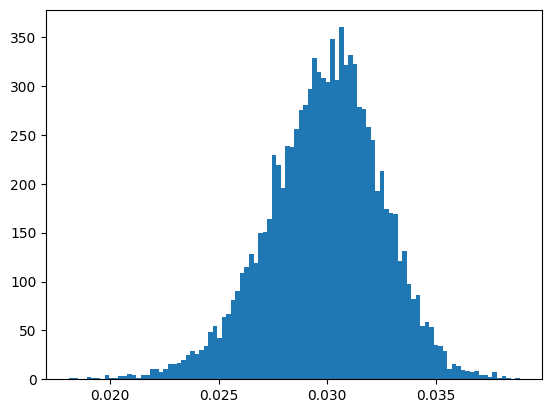

In [47]:
plt.hist(sabr_dist.rvs(size = 10000), bins = 100)   

In [31]:
sabr_dist = SabrDist(f=0.03, shift=0.03, t=1, v_atm_n=0.008, beta=0.5, rho=-0.5, volvol=.8)
urng = np.random.default_rng()
rng = NumericalInversePolynomial(sabr_dist, random_state=urng)

/Users/davidserero/Documents/Python/FwdSabr/.venv/lib/python3.13/site-packages/pysabr/models/hagan_2002_normal_sabr.py:47: RuntimeWarning: invalid value encountered in sqrt
  f_av = np.sqrt(f * k)
/Users/davidserero/Documents/Python/FwdSabr/.venv/lib/python3.13/site-packages/pysabr/models/hagan_2002_normal_sabr.py:62: RuntimeWarning: divide by zero encountered in log
  value2 = (f - k) / np.log(f / k)
/Users/davidserero/Documents/Python/FwdSabr/.venv/lib/python3.13/site-packages/pysabr/models/hagan_2002_normal_sabr.py:62: RuntimeWarning: invalid value encountered in scalar divide
  value2 = (f - k) / np.log(f / k)
/Users/davidserero/Documents/Python/FwdSabr/.venv/lib/python3.13/site-packages/pysabr/models/hagan_2002_normal_sabr.py:83: RuntimeWarning: invalid value encountered in sqrt
  f_av = np.sqrt(f * k)
/Users/davidserero/Documents/Python/FwdSabr/.venv/lib/python3.13/site-packages/pysabr/models/hagan_2002_normal_sabr.py:84: RuntimeWarning: invalid value encountered in scalar divide

UNURANError: [objid: PINV.001] 51 : cannot approximate area below PDF => (generator) condition for method violated

In [15]:
from scipy.stats import rv_continuous
class gaussian_gen(rv_continuous):
    "Gaussian distribution"
    def _pdf(self, x):
        return np.exp(-x**2 / 2.) / np.sqrt(2.0 * np.pi)
gaussian = gaussian_gen(name='gaussian')
gaussian.rvs(size=10)

array([-2.1813091 ,  0.37576375,  1.3584046 ,  0.25415434,  0.43939058,
        0.12198578,  0.39139564, -1.63915312, -0.33377777, -1.21271762])